In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.models

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
import cv2

In [3]:
# Load object to artist ID's mapping.
import json
o2a = open('oid_to_artist_id.json')
object_to_artists = json.load(o2a)

In [4]:
from utils.data_utils import *

In [5]:
dtype = torch.cuda.FloatTensor 
num_artists = 25

In [6]:
# Define number of epochs, loss, optimizer
num_epochs = 1
criterion = nn.CrossEntropyLoss()

initial_lr = 1e-1

In [7]:
def compute_hog(image):
    hog_features = []
    image_data = image.data.cpu().numpy().astype('uint8')
    
    sys.stdout.flush()
    batch_size = image.size()[0]
    
    hog = cv2.HOGDescriptor()
    for i in np.arange(batch_size):
        transposed = np.transpose(image_data[i], [1,2,0])
        hist = hog.compute(transposed)
        hog_features.append(hist)
    image.cuda()
    hog_features = np.array(hog_features)
    hog_features = torch.autograd.Variable(torch.from_numpy(hog_features), requires_grad=True).type(torch.cuda.FloatTensor)
    return hog_features.view(batch_size, -1)

In [8]:
def new_forward(model, x):

    x_copy = x[:]
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    x = x.view(x.size(0), -1)
    hog_feat = compute_hog(x_copy)
    dropout = torch.nn.Dropout().cuda()
    hog_feat = dropout(hog_feat)
#     print ('x type: ' + type(x))
#     print ('hog_feat type: ' + type(hog_feat))
    x = torch.cat((x, hog_feat), 1)
    x = model.fc(x)

    return x

In [9]:
# Helper function to run a single epoch of a model.
def run_epoch(object_to_artists, model, optimizer):
#     Alexnet used this (incorrect) line
#     optimizer = torch.optim.Adam(model.classifier.parameters(), lr=initial_lr)
    train_losses = []
    val_losses = []
    train_path = 'data/train/'
    train_batch_gen = batch_generator(train_path)
    # Load each batch of training data.
    print_train_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(train_batch_gen)
            X, Y = get_array_from_batch(train_path, current_batch, object_to_artists)
            
            # Store next batch as Torch Variables.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y)).type(torch.cuda.LongTensor)
            
            # Forward pass.
            optimizer.zero_grad()
#             batch_output = model(batch_input_var_pre)
            batch_output = new_forward(model, batch_input_var_pre)
            batch_loss = criterion(batch_output, batch_target_var)
            
            # Backpropagate.
            batch_loss.backward()
            optimizer.step()
            
            
            # Compute total loss.
            train_loss = batch_loss.data[0]
            print_train_loss += train_loss
            batch_counter += 1
            
            print_count = 50    
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] train loss: %.3f' % (batch_counter, print_train_loss / print_count))
                train_losses.append(print_train_loss/print_count)
                print_train_loss = 0

    except StopIteration:
        pass
    
    # Load validation data.
    val_path = 'data/val/'
    val_batch_gen = batch_generator(val_path)
    print_val_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(val_batch_gen)
            X, Y = get_array_from_batch(val_path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Backpropagate.
            batch_output = new_forward(model, batch_input_var_pre)
            batch_loss = criterion(batch_output, batch_target_var)
                      
            # Compute total loss.
            val_loss = batch_loss.data[0]
            print_val_loss += val_loss
#             val_losses.append(val_loss)
            batch_counter += 1

            print_count = 8
            if batch_counter % print_count == 0: # Append train loss every 10 batches.
                print('[%5d] val loss: %.3f' % (batch_counter, print_val_loss / print_count))
                val_losses.append(print_val_loss/print_count)
                print_val_loss = 0
                      
    except StopIteration:
        pass
    
    return train_losses, val_losses

In [10]:
def compute_accuracy(model, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    num_predictions = 0
    num_correct_predictions = 0
    batch_size = 50
    batch_counter = 0
    train_batches = 100
    
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
            batch_output = new_forward(model, batch_input_var_pre)
            
            predictions = torch.max(batch_output, 1)[1]
            
            # Check accuracy
            num_predictions += 50
            num_correct_predictions += torch.sum(torch.eq(predictions, batch_target_var)).data[0]
            
            batch_counter += 1
            if batch_counter == train_batches and atype == 'train':
                raise(StopIteration)
            
                      
    except StopIteration:
        accuracy = float(num_correct_predictions) / num_predictions
        print(atype + ' accuracy: ' + str(accuracy))
    

In [11]:
def graph_loss(train_loss, val_loss):
    plt.gca().cla()
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.legend()
    plt.draw()
    return 

In [12]:
def save_model(model, epoch_no, filepath_base):
    file_path = filepath_base + str(epoch_no)
    torch.save(model.state_dict(), file_path)

In [13]:
def load_model():
    pass

In [ ]:
# Different existing architectures
# Inception on Trevor's recommendation
inception = torchvision.models.inception_v3(num_classes = num_artists)

In [ ]:
# def new_forward(model, x):
#     x = 0
#     x_copy = x[:]
#     x = model.conv1(x)
#     x = model.bn1(x)
#     x = model.relu(x)
#     x = model.maxpool(x)

#     x = model.layer1(x)
#     x = model.layer2(x)
#     x = model.layer3(x)
#     x = model.layer4(x)

#     x = model.avgpool(x)
#     x = x.view(x.size(0), -1)
#     x = model.fc(x, x_copy)

#     return x


In [16]:
import sys

In [17]:
def generate_predictions(model, n_batches, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    
    all_predictions = np.zeros((50 * n_batches))
    all_labels = np.zeros((50 * n_batches))
    batch_counter = 0

    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
            batch_output = new_forward(model, batch_input_var_pre)
            
            predictions = torch.max(batch_output, 1)[1]
            predictions = predictions.view(predictions.size(0))
            start = batch_counter * 50
            all_predictions[start:start + 50] = predictions.data.cpu().numpy()
            all_labels[start:start + 50] = Y
            
            batch_counter += 1
            if batch_counter == n_batches:
                raise(StopIteration)
            
            
                      
    except StopIteration:
        pass
    
    return all_predictions, all_labels

In [22]:
import matplotlib.ticker as ticker

def plot_confusion_matrix(model, n_categories, n_batches, atype, object_to_artists):
    confusion = torch.zeros(n_categories, n_categories)
    
    predictions, labels = generate_predictions(model, n_batches, atype, object_to_artists)
    
    for i in range(predictions.shape[0]):
        prediction = predictions[i]
        label = labels[i]
        confusion[label][prediction] += 1
    
    
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax, cmap='jet')

    # Set up axes
    all_categories = ['Jan Luyken',
        'George Breitner',
        'Reinier Vinkeles',
        'Marius Bauer',
        'Isaac Israels',
        'Willem Witsen',
        'Daniel Chodowiecki',
        'Bernard Picart',
        'Rembrandt van Rijn',
        'Jacob Houbraken',
        'Antonio Tempesta',
        'Johannes Tavenraat',
        'Wenceslaus Hollar',
        'Simon Fokke',
        'Carel Cachet',
        'Jacob de Gheyn (II)',
        'Romeyn de Hooghe',
        'Meissener Manufaktur',
        'Jacques Callot',
        'Johann Sadeler (I)',
        'Jozef Israels',
        'Frans Hogenberg',
        'Crispijn van de Passe',
        'Jan van de Velde (II)',
        'Virgilius Solis (I)']
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


In [20]:
# Small resnet, pretrained, weights are being trained
resnet_small = torchvision.models.resnet18(pretrained=True).cuda()

# resnet_small.forward = new_forward
for param in resnet_small.parameters():
    param.requires_grad = False

# resnet_small.fc = nn.Sequential (
#                     nn.Dropout(),
#                     nn.Linear(1032452, num_artists),
# #                     nn.ReLU(),
# #                     nn.Dropout(),
# #                     nn.Linear(16383, 1024),
# #                     nn.ReLU(),
# #                     nn.Linear(1024, num_artists)
#                     ).cuda()
# resnet_small.fc = nn.Sequential(
#                     nn.Dropout(),
#                     nn.Linear(1032452, num_artists)
#                     ).cuda()

resnet_small.fc = nn.Linear(1032452, num_artists).cuda()

optimizer1 = torch.optim.Adam(resnet_small.fc.parameters(), lr=1e-3)
    
resnet_sm_train_losses_full = []
resnet_sm_val_losses_full = []
for i in range(5):
    print('Epoch: ' + str(i))
    sys.stdout.flush()
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_small, optimizer1)
    resnet_sm_train_losses_full += curr_train_losses_full
    resnet_sm_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_small, 'train', object_to_artists)
    compute_accuracy(resnet_small, 'test', object_to_artists)
    
# TRAIN ALL WEIGHTS!
for param in resnet_small.parameters():
    param.requires_grad = True

optimizer2 = torch.optim.Adam(resnet_small.parameters(), lr=4e-5) # smaller for all
for i in range(5):
    print('Epoch: ' + str(i))
    curr_train_losses_full, curr_val_losses_full = run_epoch(object_to_artists, resnet_small, optimizer2)
    resnet_sm_train_losses_full += curr_train_losses_full
    resnet_sm_val_losses_full += curr_val_losses_full
    compute_accuracy(resnet_small, 'train', object_to_artists)
    compute_accuracy(resnet_small, 'test', object_to_artists)
    
plot_confusion_matrix(resnet_small, 25, 100, 'test', object_to_artists)
# outfile = open('artist_classification_hog_cnn_arrays', 'w')
# outfile.write('TRAIN\n')
# outfile.write(str(resnet_sm_train_losses_full))
# outfile.write('\n')
# outfile.write(str(resnet_sm_val_losses_full))
# outfile.close()

# graph_loss(resnet_sm_train_losses_full, resnet_sm_val_losses_full)

Epoch: 0
[   50] train loss: 59.092
[  100] train loss: 25.617
[  150] train loss: 23.703
[    8] val loss: 20.546
[   16] val loss: 19.254
[   24] val loss: 17.829
train accuracy: 0.3316
test accuracy: 0.27017543859649124
Epoch: 1
[   50] train loss: 15.567
[  100] train loss: 14.589
[  150] train loss: 17.686
[    8] val loss: 18.181
[   16] val loss: 20.715
[   24] val loss: 20.903
train accuracy: 0.4352
test accuracy: 0.296140350877193
Epoch: 2
[   50] train loss: 15.323
[  100] train loss: 14.825
[  150] train loss: 14.297
[    8] val loss: 23.370
[   16] val loss: 25.779
[   24] val loss: 19.022
train accuracy: 0.4516
test accuracy: 0.3049122807017544
Epoch: 3
[   50] train loss: 14.026
[  100] train loss: 22.668
[  150] train loss: 20.264
[    8] val loss: 28.875
[   16] val loss: 27.818
[   24] val loss: 19.585
train accuracy: 0.5016
test accuracy: 0.356140350877193
Epoch: 4
[   50] train loss: 14.493
[  100] train loss: 15.828
[  150] train loss: 18.285
[    8] val loss: 20.10

NameError: name 'resnet_small_test' is not defined

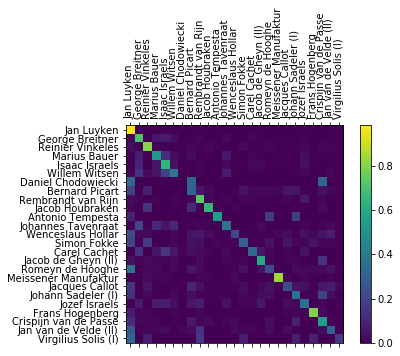

In [23]:
plot_confusion_matrix(resnet_small, 25, 100, 'test', object_to_artists)